# Transformer-based discovery of neuromodulatory co-expression modules

This is a preliminary experiment to utilize the *attentional* component of transformer-based deep learning models to identify sets of neuromodulator-related genes that tend to be expressed in some contexts but not in others.

Transformers, though *overkill*, are very good at learning higher-order interactions, especially context. The statement "Gene B predicts Gene A but only near vasculature" is something a transformer is good at learning. The output of this model is which genes *attend* to others across cells, creating gene-gene dependencies ("attention maps"). These are latent modules that are **conditional** on *space*, *region*, or other hidden cell states.

Data:
- ~200D vector per cell, + spatial coordinates & metadata (cell type, brain region)
- Each *gene* is a token
- *Positional encoding* based on spatial location

### Model spec
token_input = gene_id_embedding + f(expression_value) + cell_context_embedding, where the former is a learnable embedding of gene identity and the latter is a linear transformation of the expression value

### Architecture
Stack of transformer encoder blocks, where each block has a multi-head self-attention + feed-forward layer. Output -- one embedding per gene or cell-level aggregated embedding

### Learning
**Contrastive learning** encourages cells to learn from context, compressing them into a low-dimensional embedding space where contextual similarity is preserved. This encourages learning features of the data that discriminate spatial context.

Help to learn cell-level representations

### Interpretability
Transformers provide *attention scores* which tell you something like, "In this cell, gene A attends most to gene B and C." This can be used to identify
context-specific gene-gene depencies, cluster genes into modules based on shared attention, or to visualize maps across space. We can also *cluster* to define
co-expression modules.

### Loss
1. Masked gene modelling -- mask random 15% of genes and predict expression with MSE or Huber loss
`L_mask = mean_squared_error(predicted, true_expression)`
2. Contrastive loss -- InfoNCE between pairs of cells (negative pairs meaning random cells from distanct regions, or positive from same spatial bin or region)
`L_contrastive = -log( exp(sim(z1, z2) / τ) / sum(exp(sim(z1, zk) / τ)) )`

$L_{total} = \lambda_{mask} L_{mask} + \lambda_{contrastive} L_{contrastive}$

### Additional tests
- Use attention scores to see which genes are consistently “important” in which contexts
- Perturb gene inputs (e.g., set one to zero) and see how predictions or attention change
- Cluster cell embeddings to find distinct neuromodulatory states or microcircuit motifs

In [ ]:
# transformer_gene_modules.py
# Basic transformer with two heads -- masked gene prediction and contrastive learning

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import umap
import pandas as pd
import numpy as np
import allendata
import gc # memory handling

class AttnTransformerEncoderLayer(nn.TransformerEncoderLayer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.attn_weights = None

    def forward(self, src, src_mask=None, is_causal=False, src_key_padding_mask=None):
        src2, attn = self.self_attn(
            src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True,
            average_attn_weights=False,
            is_causal=is_causal  # <- new
        )
        self.attn_weights = attn.detach()
        return super().forward(
            src, src_mask=src_mask, is_causal=is_causal, src_key_padding_mask=src_key_padding_mask
        )

class GeneTransformer(nn.Module):
    # Constructor and hyperparameters
    # num_genes: number of unique genes in the dataset
    # d_model: dimensionality of the embeddings
    # nhead: number of attention heads
    # num_layers: number of transformer encoder layers
    # dim_feedforward: dimensionality of the feedforward network
    # dropout: dropout rate for regularization
    def __init__(self, 
                 num_genes=200,
                 d_model=128,
                 nhead=8,
                 num_layers=4,
                 dim_feedforward=256,
                 dropout=0.1):
        super().__init__()

        # Embeddings -- each gene gets a learnable embedding vector of size d
        self.gene_embedding = nn.Embedding(num_genes, d_model)
        self.expr_embedding = nn.Linear(1, d_model) # Projects scalar gene expression value into same d_model space

        # Positional encoding (optional, if using gene order)
        #self.pos_embedding = nn.Parameter(torch.randn(1, num_genes, d_model))

        # Transformer encoder first define the layer
        encoder_layer = AttnTransformerEncoderLayer(
            d_model=d_model * 2,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        # Then create the encoder itself
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Masked gene prediction head (token-level)
        self.mask_head = nn.Linear(d_model * 2, 1) # takes in your vector and outputs a scalar for each gene

        # Contrastive learning head (cell-level)
        self.pooler = nn.AdaptiveAvgPool1d(1) # pools per-gene outputs to create a single vector per cell
        self.projection_head = nn.Sequential(
            nn.Linear(d_model * 2, d_model * 2),
            nn.ReLU(),
            nn.Linear(d_model * 2, d_model * 2)
        ) # Non-linear projection for contrastive learning (SimCLR)

    def forward(self, gene_ids, expr, mask=None, return_attention=False):
        # Where B = batch size, T = number of genes, D = embedding dimension
        # gene_ids: (B, T)
        # expr: (B, T, 1)
        x_id = self.gene_embedding(gene_ids)           # (B, T, D)
        x_expr = self.expr_embedding(expr)             # (B, T, D)
        # concatenate the embeddings instead of summing
        x = torch.cat([x_id, x_expr], dim=-1)  # (B, T, 2D)

        # Capture attention weights by running layers manually
        if return_attention:
            # Only get attention from the first layer for simplicity
            layer = self.transformer.layers[0]
            attn_module = layer.self_attn
            attn_output, attn_weights = attn_module(x, x, x, need_weights=True, average_attn_weights=False)
            return attn_weights  # shape: (B, num_heads, T, T)
        
        x = self.transformer(x, src_key_padding_mask=mask)           # (B, T, 2D)

        # Masked prediction output
        mask_pred = self.mask_head(x).squeeze(-1)      # (B, T)

        # Cell-level embedding for contrastive learning
        pooled = self.pooler(x.transpose(1, 2)).squeeze(-1)  # (B, T, D) -> (B, D)
        proj = self.projection_head(pooled)            # (B, D)

        return mask_pred, proj


def mask_gene_expressions(expr, mask_ratio=0.15):
    """
    expr: Tensor of shape (B, T, 1)
    Returns:
        masked_expr: same shape, with some tokens zeroed
        mask: Bool tensor of shape (B, T) where True = masked
    """
    B, T, _ = expr.shape
    mask = torch.rand(B, T) < mask_ratio
    masked_expr = expr.clone()
    masked_expr[mask.unsqueeze(-1)] = 0.0  # or NaN, or learned <MASK> token

    return masked_expr, mask

def masked_mse_loss(pred, target, mask):
    """
    Compute MSE only on the masked gene positions.
    
    Args:
        pred:   (B, T) model predictions
        target: (B, T) ground truth expression values
        mask:   (B, T) boolean tensor (True where loss should be computed)
        
    Returns:
        Scalar loss value
    """
    masked_pred = pred[mask]
    masked_target = target[mask]
    return F.mse_loss(masked_pred, masked_target)

import torch
import torch.nn.functional as F

def contrastive_loss(embeddings, pos_mask, temperature=0.1):
    """
    embeddings: Tensor of shape (B, D)
    pos_mask:   Bool tensor of shape (B, B) where pos_mask[i, j] = True if i and j are a positive pair
    temperature: Scaling factor for similarity

    Returns:
        scalar contrastive loss (averaged over positive pairs)
    """

    embeddings = F.normalize(embeddings, dim=1)  # (B, D)
    sim_matrix = torch.matmul(embeddings, embeddings.T)  # (B, B) ; cosine similarity
    sim_matrix = sim_matrix / temperature  # Scale by temperature
    self_mask = torch.eye(sim_matrix.size(0), dtype=torch.bool, device=embeddings.device) # Mask self-similarity
    sim_matrix = sim_matrix.masked_fill(self_mask, float('-inf'))
    log_probs = F.log_softmax(sim_matrix, dim=1) # Log softmax to get log probabilities
    loss = -log_probs[pos_mask].mean() # Average over positive pairs
    return loss

def make_spatial_pos_mask(coords: torch.Tensor, distance_threshold: float) -> torch.Tensor:
    """
    Constructs a (B, B) mask where [i, j] = True if Euclidean distance between
    cell i and j is less than `distance_threshold`.

    Args:
        coords: Tensor of shape (B, 3), representing x, y, z positions of each cell
        distance_threshold: scalar (e.g., 50.0)

    Returns:
        pos_mask: Boolean tensor of shape (B, B)
    """
    B = coords.size(0)
    diff = coords.unsqueeze(1) - coords.unsqueeze(0)  # (B, B, 3)
    dists = torch.norm(diff, dim=-1)                  # (B, B)

    not_self = ~torch.eye(B, dtype=torch.bool, device=coords.device)

    pos_mask = (dists < distance_threshold) & not_self
    return pos_mask

def plot_embeddings(embeddings, title="Cell Embeddings (PCA)"):
    """
    embeddings: (N, D) tensor or numpy array of cell embeddings
    """
    embeddings_np = embeddings.detach().cpu().numpy() if isinstance(embeddings, torch.Tensor) else embeddings
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(embeddings_np)

    plt.figure(figsize=(4, 3))
    sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], s=10)
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_umap(embeddings, title="Cell Embeddings (UMAP)"):
    # Reduce to 2D using UMAP
    reducer = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1)
    reduced = reducer.fit_transform(embeddings.detach().cpu().numpy())

    # Plot the result
    plt.figure(figsize=(4, 3))
    sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], s=10)
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

We might want to learn the threshold or set a soft loss based on distance
	•	Try adding a soft loss based on distance
	•	Or a learned position embedding to see if it gives you richer structure

In [7]:

goi = 'Drd|Chrn|Chrm|Htr|Adra|Adrb|Gri|Grm|Gab|Opr|Sigmar|Cnr|Glr|Hrh|Slc6a2|Slc6a4|Slc6a3'
expression_full, gene, _, _, _ = allendata.load_preprocessed()
expression_full = expression_full[expression_full['dataset'] == 'MERFISH']
expression_full = expression_full.dropna(subset=['x_reconstructed', 'y_reconstructed', 'z_reconstructed'])

# Separate data
genelist = gene['gene_symbol'].tolist()
expression = expression_full[genelist]
metadata = expression_full[expression_full.columns.difference(genelist)]
expression = expression.fillna(0)

# Filter, subset, convert to tensor
num_cells = 1000
sample_idx = torch.randint(0, expression.shape[0], (num_cells,))
expression = expression.iloc[sample_idx]
expr = torch.tensor(expression.values, dtype=torch.float32)
expr = expr.unsqueeze(-1)
metadata = metadata.iloc[sample_idx]
coords = metadata[['x_reconstructed','y_reconstructed','z_reconstructed']]
coords = torch.tensor(coords.values, dtype=torch.float32)

gene_ids = torch.arange(expression.shape[1]).unsqueeze(0).repeat(num_cells, 1)

del goi, genelist, expression_full, metadata, expression
gc.collect()

# Move tensors to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
expr = expr.to(device)
gene_ids = gene_ids.to(device)
coords = coords.to(device)

Loading preprocessed data from disk...


Epoch 1


100%|██████████| 2/2 [00:20<00:00, 10.14s/it]


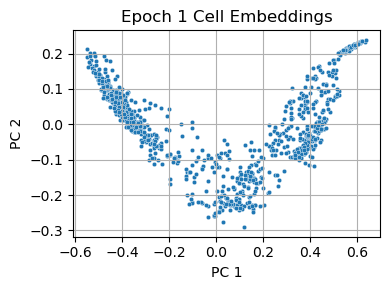

Epoch 1 | Masked Loss: 11.0924 | Contrastive Loss: 6.2770 | Total: 6.2770
Epoch 2


100%|██████████| 2/2 [00:21<00:00, 10.86s/it]


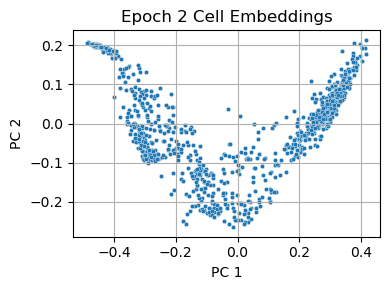

Epoch 2 | Masked Loss: 11.4600 | Contrastive Loss: 6.2050 | Total: 6.2050
Epoch 3


100%|██████████| 2/2 [00:21<00:00, 10.64s/it]


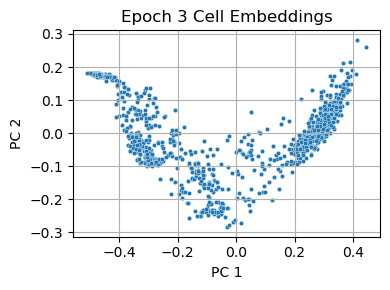

Epoch 3 | Masked Loss: 11.5123 | Contrastive Loss: 6.2062 | Total: 6.2062
Epoch 4


100%|██████████| 2/2 [00:20<00:00, 10.36s/it]


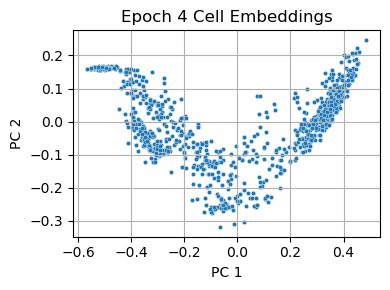

Epoch 4 | Masked Loss: 11.6740 | Contrastive Loss: 6.2069 | Total: 6.2069
Epoch 5


100%|██████████| 2/2 [00:20<00:00, 10.23s/it]


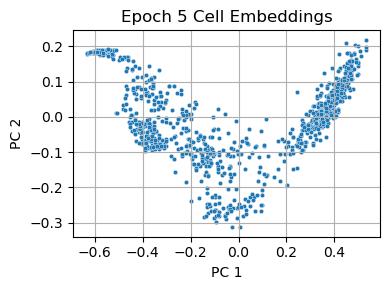

Epoch 5 | Masked Loss: 11.4829 | Contrastive Loss: 6.2050 | Total: 6.2050


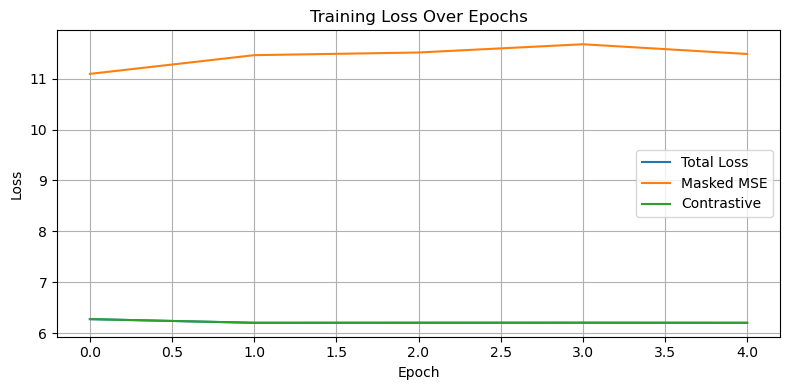

/Users/myco/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


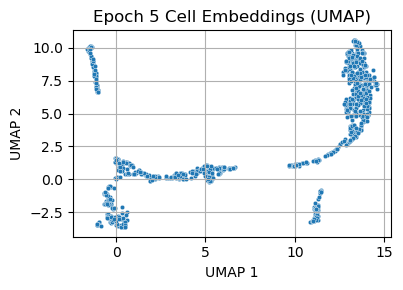

In [8]:
# Training config
num_genes = expr.shape[1]
d_model = 128
batch_size = 512
num_epochs = 5
l_contrastive = 1.0
l_mask = 0
distance_threshold = 1

writer = SummaryWriter()

# Initialize model and optimizer
model = GeneTransformer(num_genes=num_genes, d_model=d_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Loss tracking
loss_history = {"total": [], "masked": [], "contrastive": []}

# Training loop
for epoch in range(num_epochs):
    model.train()
    perm = torch.randperm(num_cells)
    epoch_mloss = 0.0
    epoch_closs = 0.0
    num_batches = 0

    print(f"Epoch {epoch+1}")

    for i in tqdm(range(0, num_cells, batch_size)):
        idx = perm[i:i+batch_size]
        batch_gene_ids = gene_ids[idx]
        batch_expr = expr[idx]
        batch_coords = coords[idx]

        masked_expr, mask = mask_gene_expressions(batch_expr, mask_ratio=0.15)
        mask_pred, cell_embedding = model(batch_gene_ids, masked_expr)

        mloss = masked_mse_loss(mask_pred, batch_expr.squeeze(-1), mask)
        pos_mask = make_spatial_pos_mask(batch_coords, distance_threshold)
        closs = contrastive_loss(cell_embedding, pos_mask)

        loss = l_mask * mloss + l_contrastive * closs
        loss.backward() # Compute gradients
        optimizer.step() # Update weights
        optimizer.zero_grad() # Reset gradients

        epoch_mloss += mloss.item()
        epoch_closs += closs.item()
        num_batches += 1

    # Record losses
    mean_mloss = epoch_mloss / num_batches
    mean_closs = epoch_closs / num_batches
    mean_total = l_mask * mean_mloss + l_contrastive * mean_closs

    loss_history["masked"].append(mean_mloss)
    loss_history["contrastive"].append(mean_closs)
    loss_history["total"].append(mean_total)

    # Save model
    torch.save(model.state_dict(), f"runs/gene_transformer_epoch{epoch+1}.pt")

    # Visualize embeddings
    with torch.no_grad():
        model.eval()
        sample_idx = torch.randint(0, num_cells, (1000,))
        sample_gene_ids = gene_ids[sample_idx]
        sample_expr = expr[sample_idx]
        masked_expr, _ = mask_gene_expressions(sample_expr)
        _, sample_embeddings = model(sample_gene_ids, masked_expr)
        plot_embeddings(sample_embeddings, title=f"Epoch {epoch+1} Cell Embeddings")

    # Record scalar losses
    writer.add_scalar("Loss/Total", mean_total, epoch)
    writer.add_scalar("Loss/Masked", mean_mloss, epoch)
    writer.add_scalar("Loss/Contrastive", mean_closs, epoch)

    # Log sample embeddings (every N epochs)
    if (epoch + 1) % 1 == 0:
        writer.add_embedding(
            sample_embeddings,
            tag=f"Epoch_{epoch+1}"
        )

    print(f"Epoch {epoch+1} | Masked Loss: {mean_mloss:.4f} | Contrastive Loss: {mean_closs:.4f} | Total: {mean_total:.4f}")

writer.flush()

# Plot loss curves
plt.figure(figsize=(8, 4))
plt.plot(loss_history["total"], label="Total Loss")
plt.plot(loss_history["masked"], label="Masked MSE")
plt.plot(loss_history["contrastive"], label="Contrastive")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.title("Training Loss Over Epochs")
plt.tight_layout()
plt.show()

# Plot UMAP
# After model evaluation (for example, after getting sample_embeddings)
with torch.no_grad():
    model.eval()
    sample_idx = torch.randint(0, num_cells, (1000,))
    sample_gene_ids = gene_ids[sample_idx]
    sample_expr = expr[sample_idx]
    masked_expr, _ = mask_gene_expressions(sample_expr)
    _, sample_embeddings = model(sample_gene_ids, masked_expr)
    
    # Visualize with UMAP
    plot_umap(sample_embeddings, title=f"Epoch {epoch+1} Cell Embeddings (UMAP)")

writer.close()

In [ ]:
def extract_all_attention(model, gene_ids, expr, return_tensor=True):
    """
    Extracts attention maps from all layers and heads.
    Args:
        model: Trained GeneTransformer
        gene_ids: (B, T) tensor
        expr: (B, T, 1) tensor
        return_tensor: If True, returns a tensor (L, B, H, T, T), else returns list of Tensors
    Returns:
        Tensor of shape (L, B, H, T, T)
    """
    model.eval()
    with torch.no_grad():
        _ = model(gene_ids, expr)

    # Collect attention from each layer
    attn_all = []
    for layer in model.transformer.layers:
        attn = layer.attn_weights  # (B, H, T, T)
        attn_all.append(attn.unsqueeze(0))  # (1, B, H, T, T)

    if return_tensor:
        return torch.cat(attn_all, dim=0)  # (L, B, H, T, T)
    else:
        return attn_all
    
def build_multilayer_gene_network(attn_tensor, gene_names, threshold=0.05):
    """
    Create a gene attention network from (L, B, H, T, T) attention tensor.
    Returns NetworkX DiGraph.
    """
    import networkx as nx
    L, B, H, T, _ = attn_tensor.shape
    attn_avg = attn_tensor.mean(dim=(0,1,2))  # (T, T)

    G = nx.DiGraph()
    for i, g1 in enumerate(gene_names):
        for j, g2 in enumerate(gene_names):
            if i != j and attn_avg[i, j] > threshold:
                G.add_edge(g1, g2, weight=attn_avg[i, j].item())
    return G

In [ ]:
## Evaluation and visualization
# UMAP/tSNE of cell embeddings
# Visualize attention weights
# Cluster attention maps
# Compute cosine similarities of attention patterns across space